In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [27]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [29]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
measurement = Base.classes.measurement 
station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [39]:
#seeing what columns are in each table 
inspector = inspect(engine)

meas_cols = inspector.get_columns('measurement')
print("measurement")
for c in meas_cols: 
    print(c['name'], c['type'])
    
sta_cols = inspector.get_columns('station')
print("\nstations")
for c in sta_cols: 
    print(c['name'], c['type'])
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()
print(f"\nThe last date is: {recent_date[0]}")

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

The last date is: 2017-08-23


One year ago it was: 2016-08-23


Text(0, 0.5, 'Precipitation Level (inches)')

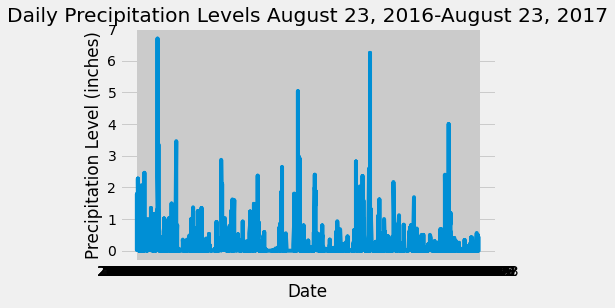

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
a_year_ago = (dt.datetime.strptime(recent_date[0],'%Y-%m-%d') - 
              dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"One year ago it was: {a_year_ago}")

# Perform a query to retrieve the data and precipitation scores
measurement_cols = (measurement.date, measurement.prcp)
prcp_data = session.query(*measurement_cols).\
            filter(measurement.date >= a_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns = ['date', 'precipitation'])

#make date the index 
prcp_df = prcp_df.set_index('date')
prcp_df = prcp_df.sort_values(by='date').dropna()
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_df.index, prcp_df['precipitation'])

        
#set  axis titles
plt.title("Daily Precipitation Levels August 23, 2016-August 23, 2017")
plt.xlabel('Date')
plt.ylabel("Precipitation Level (inches)")



In [64]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [65]:
# Design a query to calculate the total number stations in the dataset
station_cols = inspector.get_columns('station')
session.query(station.id).count()

9

In [66]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [70]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0]
most_active_sta = most_active[0]
most_active_sta

session.query(func.min(measurement.tobs), 
             func.max(measurement.tobs), 
             func.avg(measurement.tobs)).filter(measurement.station == most_active_sta).all()

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

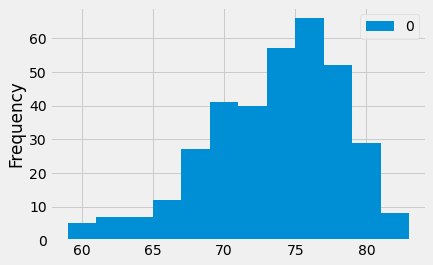

In [76]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highest_temp_obs = active_stations[0][0]

temp_obs = session.query(measurement.tobs).\
            filter(measurement.date >= "2016-08-24").\
            filter(measurement.date <= "2017-08-23").\
            filter(measurement.station == station_highest_temp_obs).all()

temp_obs_df = pd.DataFrame(temp_obs)

temp_obs_df.plot.hist(bins=12)

# Close session

In [77]:
# Close Session
session.close()